# 04 – Model Evaluation
Reload the persisted logistic/XGBoost models, reproduce the hold-out split, and report Brier/AUC plus calibration/ROC plots so readers can assess probability quality without rerunning training.


In [1]:
import sys
from pathlib import Path

def _find_project_root(start: Path) -> Path:
    for candidate in (start, *start.parents):
        if (candidate / 'src').is_dir():
            return candidate
    raise RuntimeError("Could not locate project root containing a 'src' directory.")

PROJECT_ROOT = _find_project_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


## Load processed features and saved artifacts
Reload `features_full.csv`, apply the persisted scaler, reproduce the train/test split, and bring the trained models/metadata into memory for evaluation.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from sklearn.metrics import brier_score_loss, roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve
from sklearn.model_selection import GroupShuffleSplit
from src.utils.paths import PROCESSED_DATA_DIR, MODELS_DIR, REPORTS_DIR

features_path = PROCESSED_DATA_DIR / 'features_full.csv'
metadata_path = MODELS_DIR / 'training_metadata.json'
if not (features_path.exists() and metadata_path.exists()):
    raise FileNotFoundError('Run notebooks 02 and 03 first to generate features and trained models.')

df = pd.read_csv(features_path)
with open(metadata_path, 'r', encoding='utf-8') as fh:
    metadata = json.load(fh)
base_meta = metadata['base']
adv_meta = metadata['advanced']
X_base = df[base_meta['feature_columns']]
X_adv = df[adv_meta['feature_columns']]
y = df['home_win']
scaler_base = joblib.load(MODELS_DIR / base_meta['scaler'])
scaler_adv = joblib.load(MODELS_DIR / adv_meta['scaler'])
X_base_scaled = pd.DataFrame(scaler_base.transform(X_base), columns=base_meta['feature_columns'])
X_adv_scaled = pd.DataFrame(scaler_adv.transform(X_adv), columns=adv_meta['feature_columns'])

gss = GroupShuffleSplit(n_splits=1, test_size=metadata['split']['test_size'], random_state=metadata['split']['random_state'])
train_idx, test_idx = next(gss.split(X_base_scaled, y, groups=df['game_id']))
X_test = X_base_scaled.iloc[test_idx]
X_adv_test = X_adv_scaled.iloc[test_idx]
y_test = y.iloc[test_idx]

log_reg = joblib.load(MODELS_DIR / base_meta['logistic_model'])
xgb_base = joblib.load(MODELS_DIR / base_meta['xgb_model'])
xgb_adv = joblib.load(MODELS_DIR / adv_meta['xgb_model'])


## Evaluate saved models
Compute the Brier/AUC metrics for each trained model without rerunning the training loops.

In [3]:
y_pred_log = log_reg.predict_proba(X_test)[:, 1]
y_pred_xgb_base = xgb_base.predict_proba(X_test)[:, 1]
y_pred_xgb_adv = xgb_adv.predict_proba(X_adv_test)[:, 1]
metrics = pd.DataFrame(
    {
        'logistic (base features)': {
            'Brier score': brier_score_loss(y_test, y_pred_log),
            'ROC AUC': roc_auc_score(y_test, y_pred_log),
        },
        'xgboost (base features)': {
            'Brier score': brier_score_loss(y_test, y_pred_xgb_base),
            'ROC AUC': roc_auc_score(y_test, y_pred_xgb_base),
        },
        'xgboost (advanced features)': {
            'Brier score': brier_score_loss(y_test, y_pred_xgb_adv),
            'ROC AUC': roc_auc_score(y_test, y_pred_xgb_adv),
        },
    }
).T
metrics


,Brier score,ROC AUC
logistic (base features),0.180876,0.799319
xgboost (base features),0.177164,0.802139
xgboost (advanced features),0.193779,0.768012


## Calibration + ROC plots
Overlay the validation curves for both persisted models to check probability calibration and ranking quality.

(PosixPath('/Users/ludovicopasquali/Desktop/Bocconi TA/Group Project 4/group-project-4/reports/figures/calibration.png'),
 PosixPath('/Users/ludovicopasquali/Desktop/Bocconi TA/Group Project 4/group-project-4/reports/figures/roc.png'))

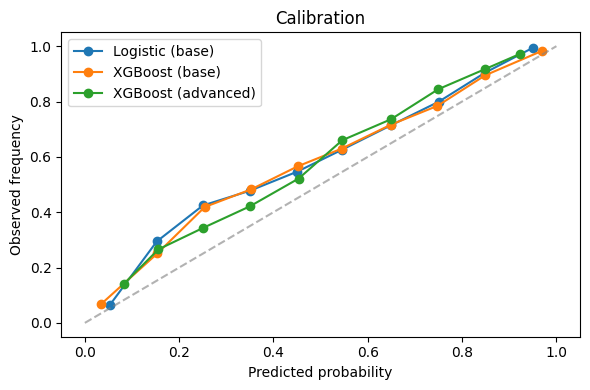

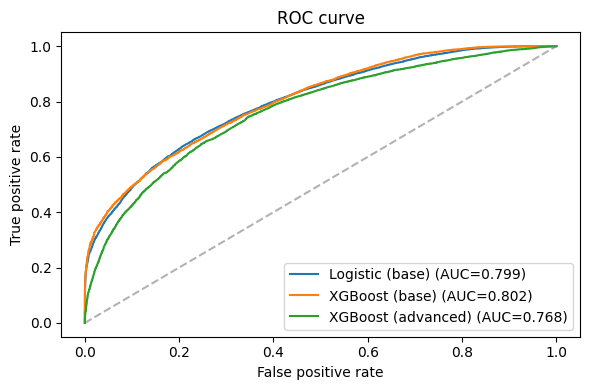

In [4]:
(REPORTS_DIR / 'figures').mkdir(parents=True, exist_ok=True)
fig_cal, ax_cal = plt.subplots(figsize=(6, 4))
model_preds = {
    'Logistic (base)': (y_pred_log, metrics.loc['logistic (base features)', 'ROC AUC']),
    'XGBoost (base)': (y_pred_xgb_base, metrics.loc['xgboost (base features)', 'ROC AUC']),
    'XGBoost (advanced)': (y_pred_xgb_adv, metrics.loc['xgboost (advanced features)', 'ROC AUC']),
}
for label, (preds, auc_val) in model_preds.items():
    frac_pos, mean_pred = calibration_curve(y_test, preds, n_bins=10)
    ax_cal.plot(mean_pred, frac_pos, marker='o', label=label)

ax_cal.plot([0, 1], [0, 1], '--', color='gray', alpha=0.6)
ax_cal.set_xlabel('Predicted probability')
ax_cal.set_ylabel('Observed frequency')
ax_cal.set_title('Calibration')
ax_cal.legend()
fig_cal.tight_layout()
cal_path = REPORTS_DIR / 'figures' / 'calibration.png'
fig_cal.savefig(cal_path, dpi=150)

fig_roc, ax_roc = plt.subplots(figsize=(6, 4))
for label, (preds, auc_val) in model_preds.items():
    fpr, tpr, _ = roc_curve(y_test, preds)
    ax_roc.plot(fpr, tpr, label=f"{label} (AUC={auc_val:.3f})")

ax_roc.plot([0, 1], [0, 1], '--', color='gray', alpha=0.6)
ax_roc.set_xlabel('False positive rate')
ax_roc.set_ylabel('True positive rate')
ax_roc.set_title('ROC curve')
ax_roc.legend()
fig_roc.tight_layout()
roc_path = REPORTS_DIR / 'figures' / 'roc.png'
fig_roc.savefig(roc_path, dpi=150)
cal_path, roc_path


## Notes
- Requires notebook 03 to have persisted the scalers and models (base + advanced) under `models/`.
- Reuses the exact train/validation split and SMOTE settings from notebook 03 to keep metrics apples-to-apples.
- Calibration/ROC figures are overwritten on each run
